# Unsupervised cross-domain image generation

- Given two related domains, S and T, it can build a generative function G that maps an input sample from S to the domain T

- Produce face emoji that are visually appealing and capture much more of the facial characteristics than the emoji created by well-trained human annotators who use the conventional tools.

## Resource

- paper: https://arxiv.org/abs/1611.02200
- code: https://github.com/yunjey/domain-transfer-network

## Architecture

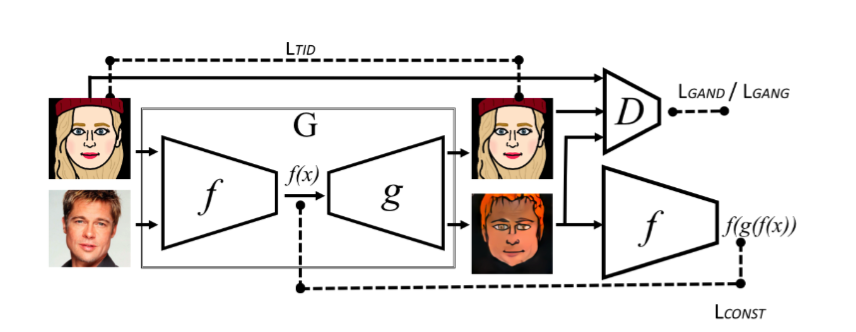

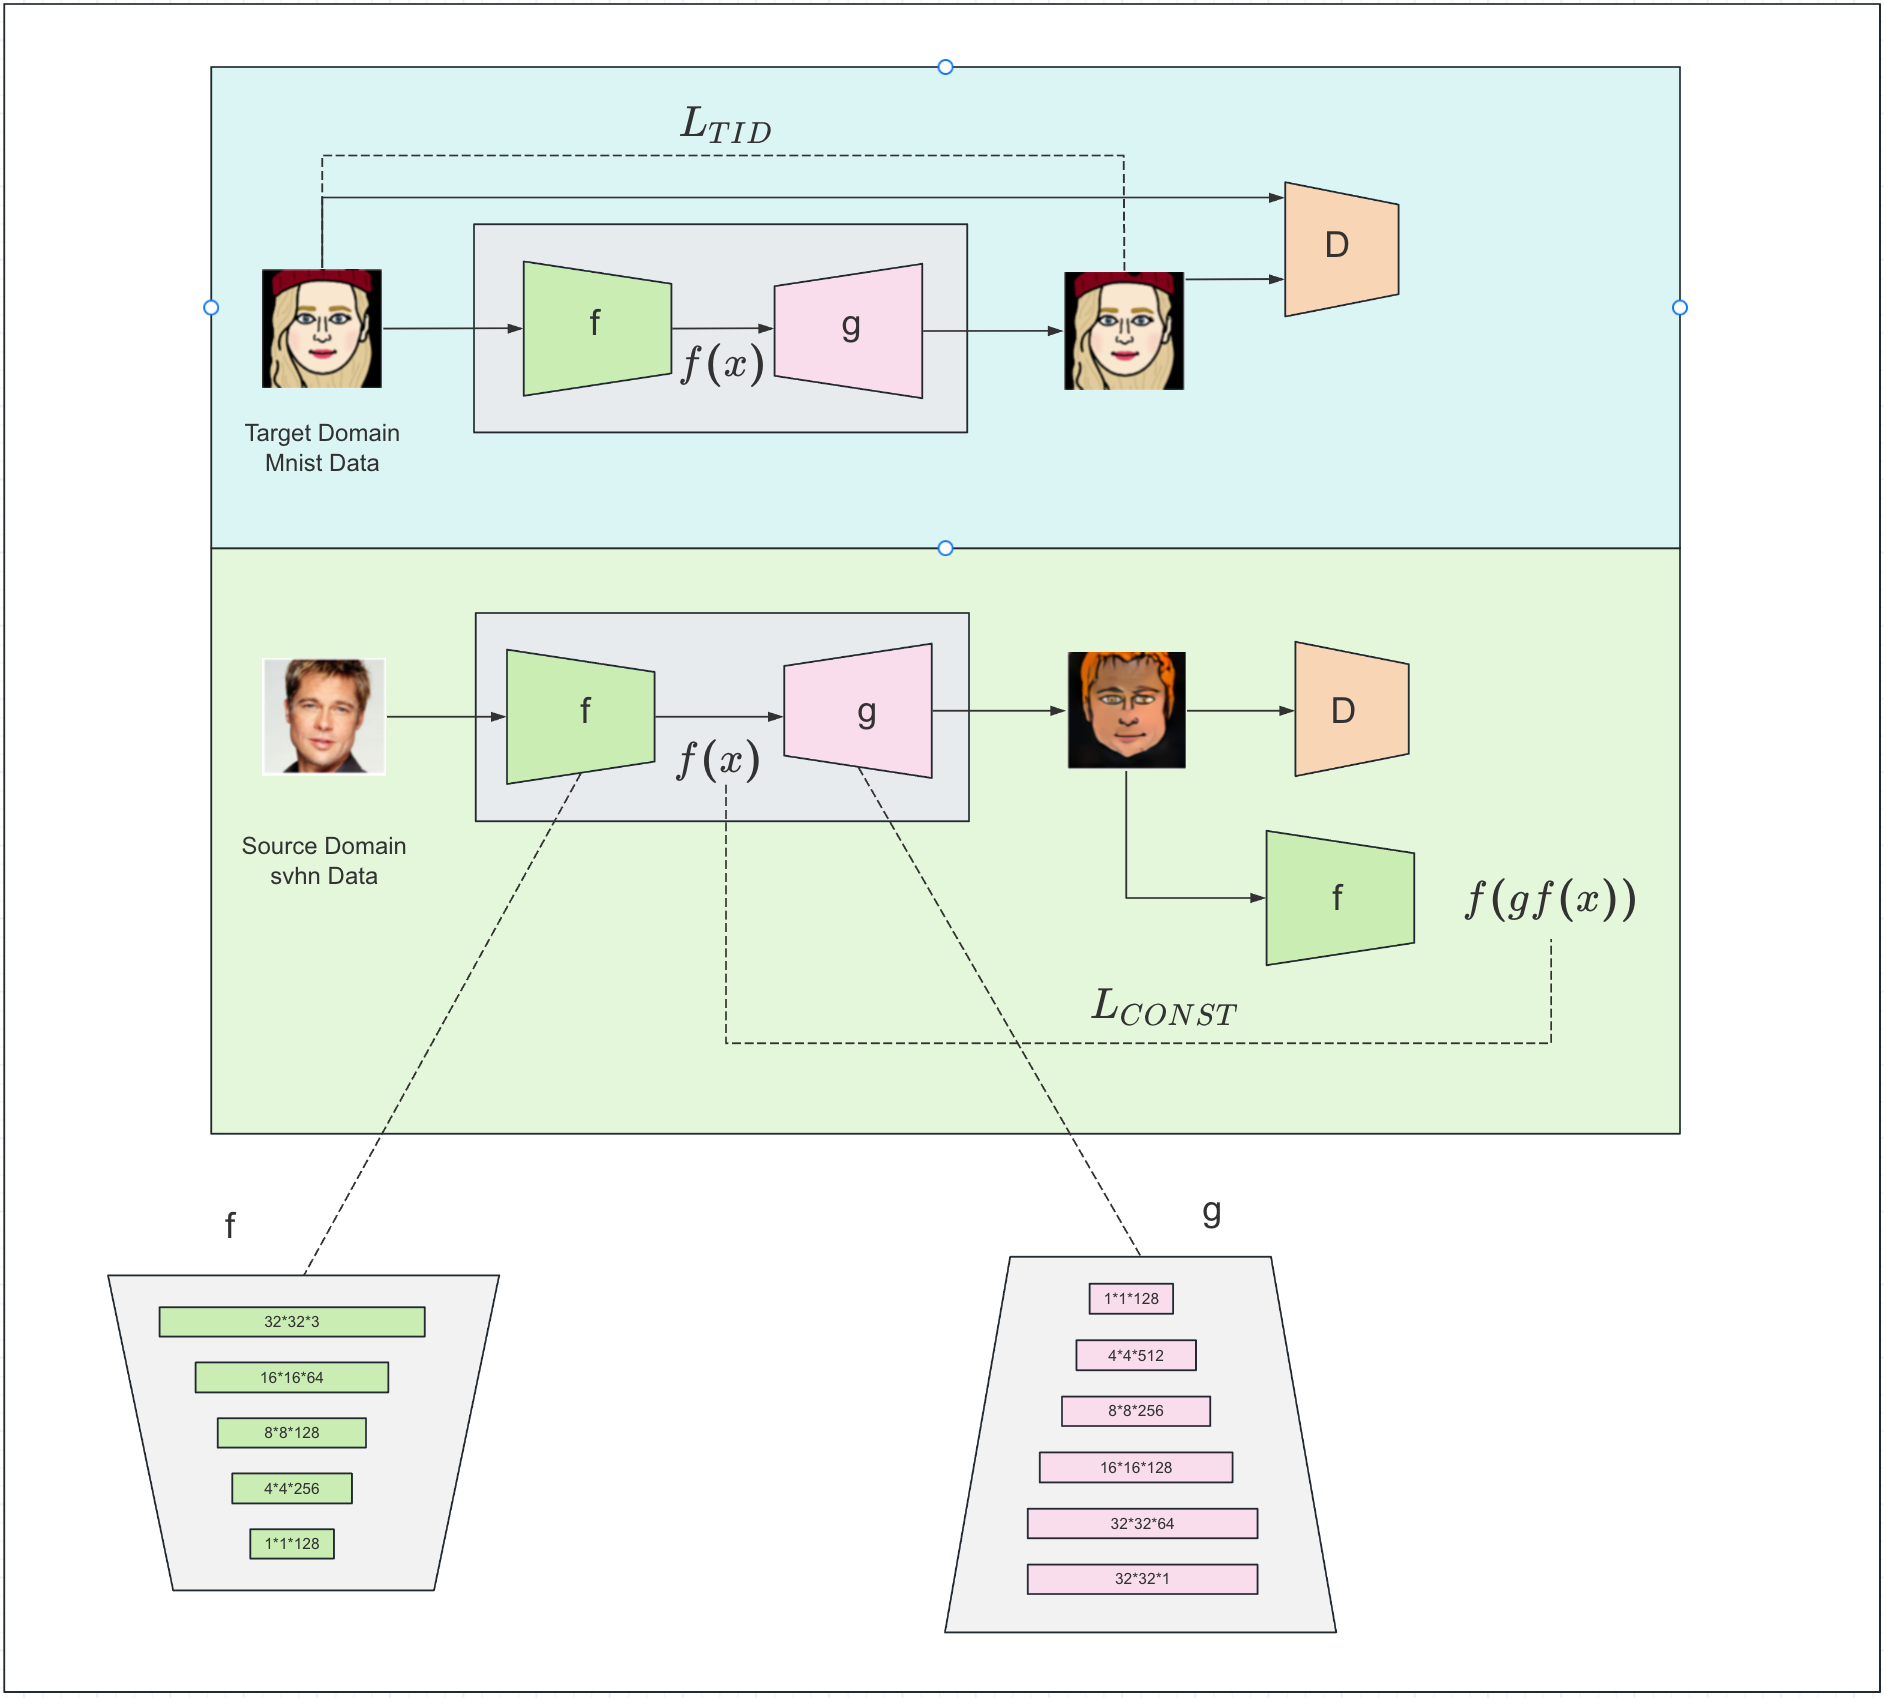

## Formulation

### Source domain loss

$R = R_{GAN} + \alpha R_{CONST}$

$R_{GAN} = max_{D} E_{x~D_S}log[1-D(G(x))] + E_{x~D_T} log[D(X)]$

$R_{CONST} = E_{x~D_{s}}d(f(x),f(G(x)))$

### Traget domain loss

#### Discriminator's Loss

$L_{D}= - E_{x\in s}logD_{1}(g(f(x))) - E_{x\in t}logD_{2}(G(f(x))) - E_{x \in t}logD_{3}(x)$

- s and t are pdf
- $D_1 , D_2, D_3$ are same discriminator, which evaluates the authenticity of images (are they real or generated)

#### Generator's Loss

$L_{G} = L_{GANG} + \alpha L_{CONST} + \beta L_{TID} + \gamma L_{TV}$

$L_{GANG} = - E_{x \in s}logD_{3}(g(f(x))) - E_{x \in t}logD_{3}(g(f(x)))$

$L_{CONST} = \sum_{x \in s} d(f(x),f(g(f(x))))$

$L_{TID}=\sum_{x \in t} d_{2}(x,G(x))$

- $L_G$ Total loss for generator.
- $L_{GANG}$ is the adversarial loss for the generator.
- $L_{CONST}$ represents a consistency loss. It measures the distance between the feature representation of the original input and the output.
- $L_{TID}$ is target identity Loss, it measures the distance between the target sample and its generated version.
- $L_{TV}$ is a regularization loss.
- $d , d_2$ is $L_2$ Normal.

## Implementation

### Import library

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pickle
from tensorflow.keras.layers import Resizing
import os
import numpy as np
import pickle
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

In [6]:
!cd /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data

### Download svhn data

In [ ]:
!mkdir -p mnist
!mkdir -p svhn

!wget -O svhn/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -O svhn/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!wget -O svhn/extra_32x32.mat http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

--2024-06-08 07:24:04--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘svhn/train_32x32.mat’

svhn/train_32x32.ma  55%[==========>         ]  96.49M  3.37MB/s    eta 28s    ^C
--2024-06-08 07:24:39--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘svhn/test_32x32.mat’

svhn/test_32x32.mat   2%[                    ]   1.50M   248KB/s    eta 4m 31s ^C
--2024-06-08 07:24:47--  http://ufldl.stanford.edu/housenumbers/extra_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.6

### Download Mnist data and resize

In [ ]:
# Specify the path to save the MNIST data
data_dir = '/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/mnist'

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Create a Resize layer to resize images from 28x28 to 32x32
resize_layer = Resizing(32, 32, interpolation='bilinear')

# Expand the dimensions of the images to add a channel dimension (grayscale)
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Apply the resize operation to training and test images
train_images_resized = resize_layer(train_images)
test_images_resized = resize_layer(test_images)

# Normalize the images to [0, 1]
train_images_resized = train_images_resized / 255.0
test_images_resized = test_images_resized / 255.0

# Save as dictionary structure and serialize to pickle file
train_data = {'X': train_images_resized.numpy(), 'y': train_labels}
test_data = {'X': test_images_resized.numpy(), 'y': test_labels}

with open(f'{data_dir}/mnist_train.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open(f'{data_dir}/mnist_test.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print('MNIST dataset successfully saved!')

### Load data

In [6]:
!cd /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data

In [80]:
def load_svhn(image_dir, split='train'):
    print ('loading svhn image dataset..')
        
#     if self.model.mode == 'pretrain':
#         image_file = 'extra_32x32.mat' if split=='train' else 'test_32x32.mat'
#     else:
#         image_file = 'train_32x32.mat' if split=='train' else 'test_32x32.mat'
    image_file = 'train_32x32.mat' if split=='train' else 'test_32x32.mat'        
    image_dir = os.path.join(image_dir, image_file)
    svhn = scipy.io.loadmat(image_dir)
    images = np.transpose(svhn['X'], [3, 0, 1, 2]) / 127.5 - 1
    labels = svhn['y'].reshape(-1)
    labels[np.where(labels==10)] = 0
    print ('finished loading svhn image dataset..!')
    return images, labels

In [8]:
def load_mnist(image_dir, split='train'):
    print ('loading mnist image dataset..')
    image_file = 'mnist_train.pkl' if split=='train' else 'mnist_test.pkl'
    image_dir = os.path.join(image_dir, image_file)
    with open(image_dir, 'rb') as f:
        mnist = pickle.load(f)
    images = mnist['X'] / 127.5 - 1
    labels = mnist['y']
    print ('finished loading mnist image dataset..!')
    return images, labels

In [9]:
def merge_images(sources, targets, k=10):
    _, h, w, _ = sources.shape
    row = int(np.sqrt(self.batch_size))
    merged = np.zeros([row*h, row*w*2, 3])

    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[i*h:(i+1)*h, (j*2)*h:(j*2+1)*h, :] = s
        merged[i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h, :] = t
    return merged

In [81]:
svhn_dir = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/svhn"
mnist_dir = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/data/mnist"

svhn_images, _ = load_svhn(svhn_dir, split='train')
mnist_images, _ = load_mnist(mnist_dir, split='train')

loading svhn image dataset..
finished loading svhn image dataset..!
loading mnist image dataset..
finished loading mnist image dataset..!


In [13]:
svhn_images[1].shape

(32, 32, 3)

In [14]:
mnist_images[1].shape

(32, 32, 1)

### Plotting images

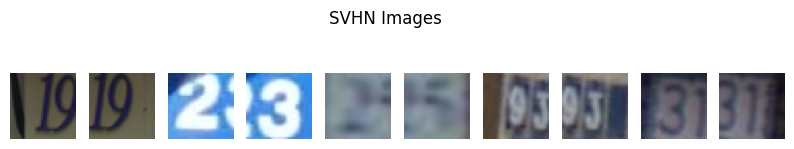

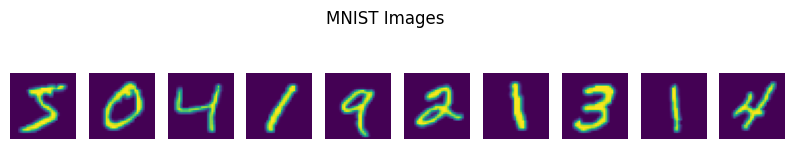

In [15]:
# Plotting SVHN and MNIST images
def plot_images(images, title, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] + 1) / 2)  # Normalize back to [0, 1] for display
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot 10 images from SVHN
plot_images(svhn_images, "SVHN Images", num_images=10)

# Plot 10 images from MNIST
plot_images(mnist_images, "MNIST Images", num_images=10)

### Extractor

In [16]:
# Define the content extractor model
# input 32*32*3 
# output 1*1*128


def content_extractor_model():
    
    inputs = tf.keras.Input(shape=(32, 32, 3))
    
    # Define layers
    x = layers.Conv2D(64, (3, 3), padding='same', strides=2, kernel_initializer='glorot_uniform')(inputs)
    x = layers.BatchNormalization(momentum=0.95)(x)
    x = tf.nn.relu(x)

    x = layers.Conv2D(128, (3, 3), padding='same', strides=2, kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x)
    x = tf.nn.relu(x)

    x = layers.Conv2D(256, (3, 3), padding='same', strides=2, kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x)
    x = tf.nn.relu(x)

    x = layers.Conv2D(128, (4, 4), padding='valid', kernel_initializer='glorot_uniform')(x)
    x = layers.BatchNormalization(momentum=0.95)(x)
    outputs = tf.nn.tanh(x)

    return tf.keras.Model(inputs, outputs)


#### Padding = 'same'
- **'same' padding** means that the input tensor is padded in such a way that the output tensor has the same height and width as the input tensor.
- Padding is added equally to both sides of the input. If the kernel size is even, extra padding may be added to the bottom and right sides.
- This is useful when you want the output to have the same spatial dimensions as the input.

#### Padding = 'valid'
- **'valid' padding** means no padding is added to the input tensor. The convolution is only applied to valid positions where the entire filter fits inside the input dimensions.
- This results in an output tensor that is smaller than the input tensor, depending on the filter size and stride.
- This is useful when you want to reduce the spatial dimensions of the output.

#### Calculation of Output Shape

##### Same Padding:
For a given input dimension \(I\), kernel size \(K\), stride \(S\), and padding \(P\), the output dimension \(O\) is calculated as:
$ O = \left\lceil \frac{I}{S} \right\rceil $

##### Valid Padding:
For the same parameters, the output dimension \(O\) is calculated as:
$ O = \left\lfloor \frac{I - K + 1}{S} \right\rfloor $

#### Example Calculations:

##### Same Padding:
For an input of 32x32, kernel size of 3x3, and stride of 1:
$ O = \left\lceil \frac{32}{1} \right\rceil = 32 $

##### Valid Padding:
For an input of 32x32, kernel size of 3x3, and stride of 1:
$ O = \left\lfloor \frac{32 - 3 + 1}{1} \right\rfloor = 30 $


### Generator

In [17]:
# Define the Generator
# input 1*1*128
# output 32*32*1

def generator_model():
    inputs = tf.keras.Input(shape=(1, 1, 128))
    x = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=1, padding='valid', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    outputs = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', activation=tf.nn.tanh, use_bias=False)(x)
    return tf.keras.Model(inputs, outputs)


### Discriminator

In [18]:
# Define the Discriminator
# input 32*32*3
# output 1

def discriminator_model_rgb():
    inputs = tf.keras.Input(shape=(32, 32, 3))  # Define input with 3 channels
    
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=tf.nn.relu, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(1, (4, 4), strides=1, padding='valid', use_bias=False)(x)
    x = tf.keras.layers.Flatten()(x)
    
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

In [19]:
# Define the Discriminator
# input 32*32*1
# output 1

def discriminator_model():
    inputs = tf.keras.Input(shape=(32, 32, 1))  # Define input with 1 channels
    
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=tf.nn.relu, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(1, (4, 4), strides=1, padding='valid', use_bias=False)(x)
    x = tf.keras.layers.Flatten()(x)
    
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

### Source domain loss

In [20]:
learning_rate=0.0003

# Define optimizers
d_optimizer_src = tf.keras.optimizers.Adam(learning_rate=learning_rate)
g_optimizer_src = tf.keras.optimizers.Adam(learning_rate=learning_rate)
f_optimizer_src = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [21]:
# Define the loss functions
# def d_loss_src(real_output, fake_output):
#     real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
#         y_true=tf.ones_like(real_output), 
#         y_pred=real_output
#     )
#     fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
#         y_true=tf.zeros_like(fake_output), 
#         y_pred=fake_output
#     )
#     total_loss = real_loss + fake_loss
#     return total_loss

# Discriminator loss
def d_loss_src(logits):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        y_true=tf.zeros_like(logits), 
        y_pred=logits
    )
# Generator loss
def g_loss_src(logits):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        y_true=tf.ones_like(logits), 
        y_pred=logits
    )
# L2 normal for fx and fgfx
def f_loss_src(fx, fgfx):
    return tf.reduce_mean(tf.square(fx - fgfx)) * 15.0

In [22]:
# Define the source training step
@tf.function
def train_step_source(extractor, generator, discriminator, svhn_images): 
    
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape, tf.GradientTape() as f_tape:   
        # noise
        fx = extractor(svhn_images)
        fake_images = generator(fx)
        logits = discriminator(fake_images)
        
        # change greyscale image to rgb imag
        rgb_fake_image = tf.image.grayscale_to_rgb(fake_images)
        fgfx = extractor(rgb_fake_image)  
        
        d_loss = d_loss_src(logits)
        g_loss = g_loss_src(logits)
        f_loss = f_loss_src(fx, fgfx)

    # Compute the gradients
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    f_grads = f_tape.gradient(f_loss, extractor.trainable_variables)

    # Apply the gradients to the variables
    d_optimizer_src.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    g_optimizer_src.apply_gradients(zip(g_grads, generator.trainable_variables))
    f_optimizer_src.apply_gradients(zip(f_grads, extractor.trainable_variables))
    return d_loss, g_loss, f_loss


### Target domain loss

#### Target domain loss

In [23]:
d_optimizer_trg = tf.keras.optimizers.Adam(learning_rate=learning_rate)
g_optimizer_trg = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [24]:
# Define the target training step
@tf.function
def train_step_target(extractor, generator, discriminator, mnist_images): 
    
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape, tf.GradientTape() as f_tape:   

        # target domain (mnist)
        # noise
        mnist_images_rgb = tf.image.grayscale_to_rgb(mnist_images)
        fx = extractor(mnist_images_rgb)
        reconst_images = generator(fx)
        logits_fake = discriminator(reconst_images)
        logits_real = discriminator(mnist_images)
        
        # Discriminator loss for fake target images
        d_loss_fake_trg = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)
        # Discriminator loss for real target images
        d_loss_real_trg = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
        # Total discriminator loss
        d_loss_trg = tf.reduce_mean(d_loss_fake_trg) + tf.reduce_mean(d_loss_real_trg)

        # Generator loss for fake target images (should be classified as real)
        g_loss_fake_trg = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
        # Generator constant loss (e.g., L2 loss between target and reconstructed images)
        g_loss_const_trg = tf.reduce_mean(tf.square(mnist_images - reconst_images)) * 15.0
        # Total generator loss
        g_loss_trg = tf.reduce_mean(g_loss_fake_trg) + g_loss_const_trg
                                                      
                                                      
    # Compute the gradients
    d_grads_trg = d_tape.gradient(d_loss_trg, discriminator.trainable_variables)
    g_grads_trg = g_tape.gradient(g_loss_trg, generator.trainable_variables)

    # Apply the gradients to the variables
    d_optimizer_trg.apply_gradients(zip(d_grads_trg, discriminator.trainable_variables))
    g_optimizer_trg.apply_gradients(zip(g_grads_trg, generator.trainable_variables))
    return d_loss_trg, g_loss_trg


### Training

In [25]:
learning_rate=0.0003

In [26]:
extractor = content_extractor_model()
generator = generator_model()
discriminator = discriminator_model()

In [27]:
num_epochs = 10  
batch_size = 64  

# Convert the numpy array to a tf.data.Dataset
svhn_dataset = tf.data.Dataset.from_tensor_slices(svhn_images).batch(batch_size)

# Perform the training for source domian
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Initialize loss accumulation variables
    total_d_loss = 0.0
    total_g_loss = 0.0
    total_f_loss = 0.0
    num_batches = 0
    for svhn_batch in svhn_dataset:
        d_loss, g_loss, f_loss = train_step_source(extractor, generator, discriminator, svhn_batch)
        # Accumulation loss
        total_d_loss += d_loss.numpy()
        total_g_loss += g_loss.numpy()
        total_f_loss += f_loss.numpy()
        num_batches += 1
    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    avg_f_loss = total_f_loss / num_batches
    print(f"Epoch {epoch+1}: avg_d_loss: {avg_d_loss}, avg_g_loss: {avg_g_loss}, avg_f_loss: {avg_f_loss}")   

Epoch 1/10
Epoch 1: avg_d_loss: 0.008056057825747165, avg_g_loss: 19.084777966805422, avg_f_loss: 4.149990178801986e-05
Epoch 2/10
Epoch 2: avg_d_loss: 2.139697508839122e-09, avg_g_loss: 19.982576808346412, avg_f_loss: 2.9645511195197717e-09
Epoch 3/10
Epoch 3: avg_d_loss: 1.0444311160228144e-09, avg_g_loss: 20.704067856567917, avg_f_loss: 8.865130432817646e-10
Epoch 4/10
Epoch 4: avg_d_loss: 5.496040003503209e-10, avg_g_loss: 21.329999355665983, avg_f_loss: 3.6470772476831475e-10
Epoch 5/10
Epoch 5: avg_d_loss: 3.303728507406862e-10, avg_g_loss: 21.843198506384436, avg_f_loss: 1.6043164753433144e-10
Epoch 6/10
Epoch 6: avg_d_loss: 2.0409144728425245e-10, avg_g_loss: 22.32096501312922, avg_f_loss: 7.623388239413622e-11
Epoch 7/10
Epoch 7: avg_d_loss: 1.7167357375552857e-10, avg_g_loss: 22.498886369930084, avg_f_loss: 1.2491675147849102e-09
Epoch 8/10
Epoch 8: avg_d_loss: 1.2536193974093374e-09, avg_g_loss: 21.854834073495656, avg_f_loss: 2.8316278994013084e-10
Epoch 9/10
Epoch 9: avg_d

In [28]:
num_epochs = 10  
batch_size = 64  

# Convert the numpy array to a tf.data.Dataset
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_images).batch(batch_size)

# Perform the training for target domain


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Initialize loss accumulation variables
    total_d_loss = 0.0
    total_g_loss = 0.0
    num_batches = 0
    for mnist_batch in mnist_dataset:
        d_loss, g_loss = train_step_target(extractor, generator, discriminator, mnist_batch)
        # Accumulation loss
        total_d_loss += d_loss.numpy()
        total_g_loss += g_loss.numpy()
        num_batches += 1
    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    print(f"Epoch {epoch+1}: avg_d_loss: {avg_d_loss}, avg_g_loss: {avg_g_loss}, avg_f_loss: {avg_f_loss}")   

Epoch 1/10
Epoch 1: avg_d_loss: 1.5634138275708345, avg_g_loss: 1.39616746939957, avg_f_loss: 9.049422152777751e-13
Epoch 2/10
Epoch 2: avg_d_loss: 1.2481856526953559, avg_g_loss: 1.2657529741152327, avg_f_loss: 9.049422152777751e-13
Epoch 3/10
Epoch 3: avg_d_loss: 0.6980788741085872, avg_g_loss: 5.2567101798327105, avg_f_loss: 9.049422152777751e-13
Epoch 4/10
Epoch 4: avg_d_loss: 0.5333281682921992, avg_g_loss: 5.34987100681728, avg_f_loss: 9.049422152777751e-13
Epoch 5/10
Epoch 5: avg_d_loss: 0.677162003461323, avg_g_loss: 1.59712561013008, avg_f_loss: 9.049422152777751e-13
Epoch 6/10
Epoch 6: avg_d_loss: 1.9254087395330608, avg_g_loss: 1.5078213616008205, avg_f_loss: 9.049422152777751e-13
Epoch 7/10
Epoch 7: avg_d_loss: 0.36367814477159777, avg_g_loss: 2.329966526254138, avg_f_loss: 9.049422152777751e-13
Epoch 8/10
Epoch 8: avg_d_loss: 0.2748610016379529, avg_g_loss: 2.9263941994381706, avg_f_loss: 9.049422152777751e-13
Epoch 9/10
Epoch 9: avg_d_loss: 0.1773529007339846, avg_g_loss:

### Save Model

In [33]:
path = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model"

In [37]:
# Define the saving path
path = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model"

# Save the model
extractor.save(f"{path}/extractor")
generator.save(f"{path}/generator")
discriminator.save(f"{path}/discriminator")


INFO:tensorflow:Assets written to: /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model/extractor/assets


INFO:tensorflow:Assets written to: /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model/extractor/assets


INFO:tensorflow:Assets written to: /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model/generator/assets


INFO:tensorflow:Assets written to: /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model/generator/assets


INFO:tensorflow:Assets written to: /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model/discriminator/assets


INFO:tensorflow:Assets written to: /Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model/discriminator/assets


### Load Model

In [35]:
!cd "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/week4/model"

In [38]:
from tensorflow.keras.models import load_model

# Load models
extractor = load_model(f"{path}/extractor")
generator = load_model(f"{path}/generator")
discriminator = load_model(f"{path}/discriminator")

# check the model loading
print("Extractor model loaded successfully")
print("Generator model loaded successfully")
print("Discriminator model loaded successfully")


Extractor model loaded successfully
Generator model loaded successfully
Discriminator model loaded successfully


### Test

In [103]:
m1 = mnist_images[1]

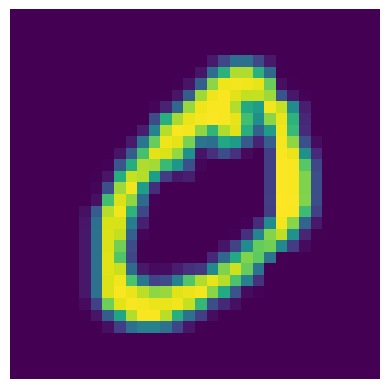

In [129]:
plt.imshow(m1)
plt.axis("off")
plt.show()

In [106]:
m1_tensor = tf.convert_to_tensor(m1, dtype=tf.float32)

In [109]:
# Add a batch dimension
m1_tensor = tf.expand_dims(m1_tensor, axis=0)  # This will make it (1, 32, 32, 1)

In [110]:
m1_rgb = tf.image.grayscale_to_rgb(m1_tensor)

In [113]:
fx1 = extractor(m1_rgb)

In [121]:
g1 = generator(fx1)

In [125]:
g1.shape

TensorShape([1, 32, 32, 1])

In [126]:
image_data = np.squeeze(g1)  # Remove single-dimensional entries

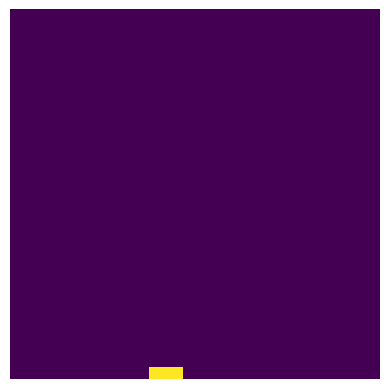

In [128]:
plt.imshow(image_data)
plt.axis("off")
plt.show()